In [1]:
import sys
import time
import os.path
from glob import glob
from datetime import datetime, timedelta

# data tools
import h5py
import pygrib
import numpy as np
import numba as nb
import pandas as pd
import netCDF4 as nc

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/PUBLISH/WFRT-PP-DEV/')
sys.path.insert(0, '/glade/u/home/ksha/PUBLISH/WFRT-PP-DEV/libs/')

import utils

# !!!! <---- change to your namelist
from namelist_casper import * 
from namelist_plot import *
import plot_lib as plib

In [2]:
import importlib
importlib.reload(utils)

<module 'utils' from '/glade/u/home/ksha/PUBLISH/WFRT-PP-DEV/libs/utils.py'>

In [3]:
importlib.reload(plib)

<module 'plot_lib' from '/glade/u/home/ksha/PUBLISH/WFRT-PP-DEV/libs/plot_lib.py'>

In [4]:
#importlib.reload(namelist_plot)
from namelist_plot import *

In [5]:
# graph tools
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [6]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

In [7]:
dt_fmt = '20220413'
if dt_fmt == 'auto':
    dt_utc_now = datetime.utcnow()
    dt_fmt_string = datetime.strftime(dt_utc_now, '%Y%m%d')
else:
    dt_fmt_string = dt_fmt
    dt_utc_now = datetime.strptime(dt_fmt_string, '%Y%m%d')

In [8]:
with h5py.File(path_domain_namelist, 'r') as h5io:
    lat_bc = h5io['bc_lat'][...] # lats of the BC domain
    lon_bc = h5io['bc_lon'][...] # lons of the BC domain
    lon_4km = h5io['lon_4km'][...]
    lat_4km = h5io['lat_4km'][...]
    land_mask_bc = h5io['land_mask_bc'][...] # selecting OCEAN grids from the BC domain
    land_mask_bc_4km = h5io['land_mask_bc_4km'][...]
# ocean_mask_bc = np.logical_not(land_mask_bc) # selecting LAND grids from the BC domain
grid_shape = lon_bc.shape

In [9]:
output_dir = output_dir_namelist.format(dt_fmt_string)
name_output = filename_CNN_output_namelist.format(dt_fmt_string)

with h5py.File(output_dir+name_output, 'r') as h5io:
    CNN_output = h5io['gefs_apcp'][...]
    
CNN_output[..., land_mask_bc] = np.nan

In [10]:
def accum_slide_window_stn(data, accum_window, output_freq, skip_start):

    inds_start = []
    inds_end = []
    
    EN, N_lead = data.shape

    N_output = (N_lead - accum_window - skip_start) // output_freq + 1

    Accum_output = np.empty((EN, N_output))

    for n in range(N_output):

        ind_start = skip_start+n*output_freq
        ind_end = ind_start+accum_window
        Accum_output[:, n, ...] = np.nansum(data[:, ind_start:ind_end, ...], axis=1)

        inds_start.append(ind_start)
        inds_end.append(ind_end)
        
    return Accum_output, inds_start, inds_end

In [11]:
CNN_output.shape

(75, 54, 48, 112)

In [12]:
STN_LOCs

{'BCK': (-123.91388888888889, 48.50333333333333),
 'CMX': (-125.09444444444443, 49.643055555555556),
 'COQ': (-122.77777777777777, 49.355555555555554),
 'CRS': (-116.51666666666667, 49.1),
 'ELK': (-125.76416666666667, 49.87277777777778),
 'PYN': (-122.6375, 55.35),
 'STA': (-122.32638888888889, 49.5575),
 'WAH': (-121.61861111111111, 49.231944444444444),
 'WON': (-121.8, 56.733333333333334),
 'YRV': (-118.18333333333334, 50.96666666666667),
 'YVR': (-123.18333333333334, 49.18333333333333),
 'YXJ': (-120.73333333333333, 56.233333333333334)}

In [18]:
stn_names = list(STN_LOCs.keys())
stn_lons = []
stn_lats = []

for stn in stn_names:
    stn_lons.append(STN_LOCs[stn][0])
    stn_lats.append(STN_LOCs[stn][1])
    
stn_lons = np.array(stn_lons)
stn_lats = np.array(stn_lats)

In [20]:
indx, indy = utils.grid_search(lon_bc, lat_bc, stn_lons, stn_lats)

In [21]:
L_stn = len(stn_names)

In [22]:
Qs = [0.1, 0.25, 0.5, 0.75, 0.9]
Qs_str = ['P10', 'P25', 'P50', 'P75', 'P90']

In [23]:
LEADs_3H_ind = np.arange(0, N_leads_namelist, dtype=np.int)
LEADs_3H_hrs = np.arange(9.0, 24*7+3, 3)[:N_leads_namelist]

In [24]:
COLORS = [plib.xcolor('light steel blue'), plib.xcolor('corn flower blue'), plib.xcolor('slate blue')]

In [ ]:
fcst_hrs = LEADs_3H_hrs
accum = 3
accum_str = '3 hourly'
stn_name = 'XXX'

/glade/work/ksha/py_env_20200417/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/glade/work/ksha/py_env_20200417/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/glade/work/ksha/py_env_20200417/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the py

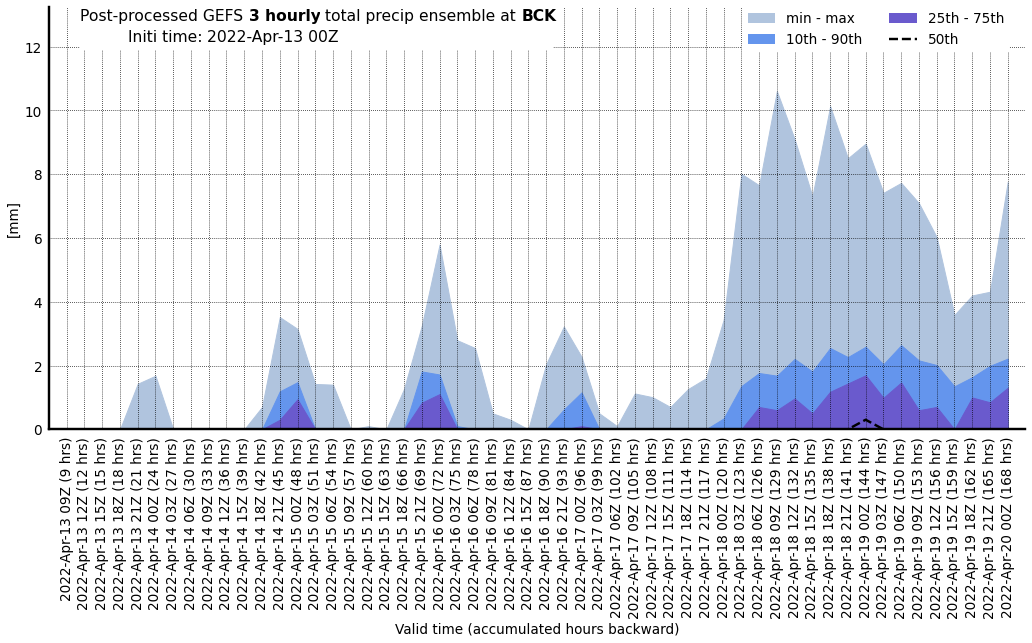

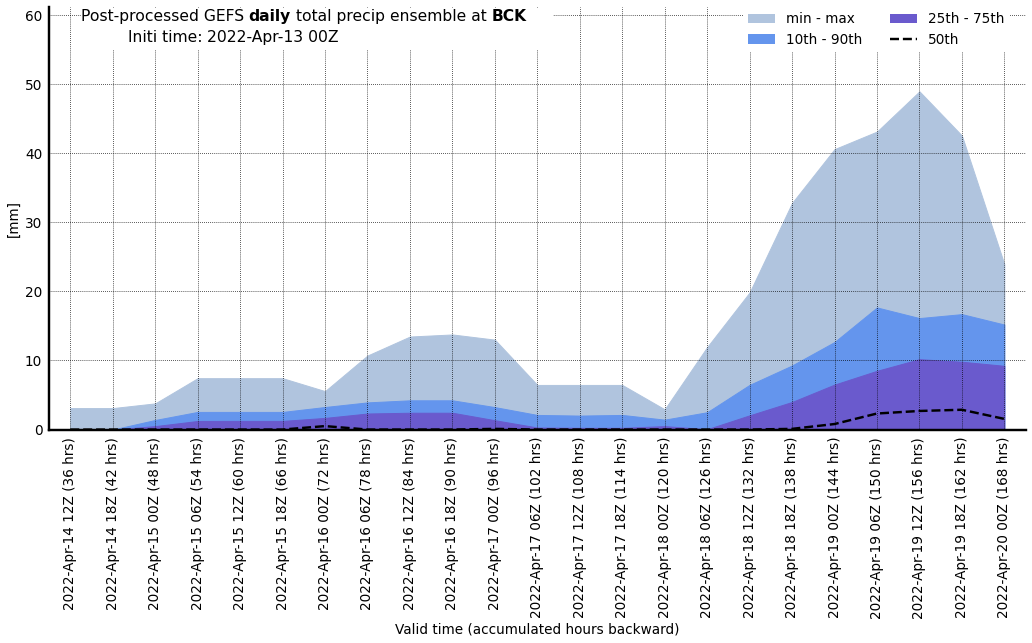

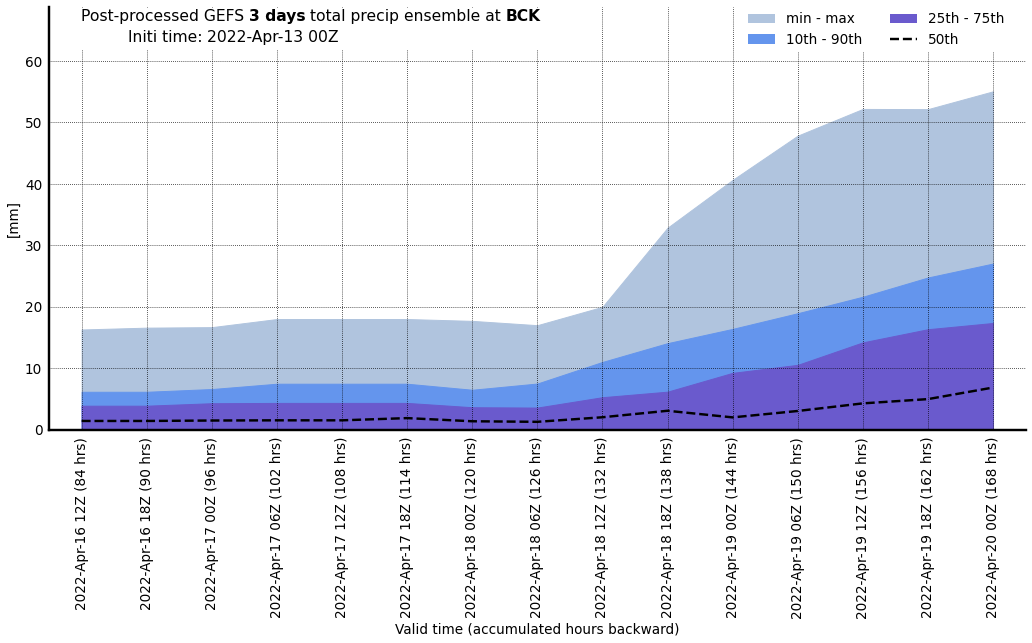

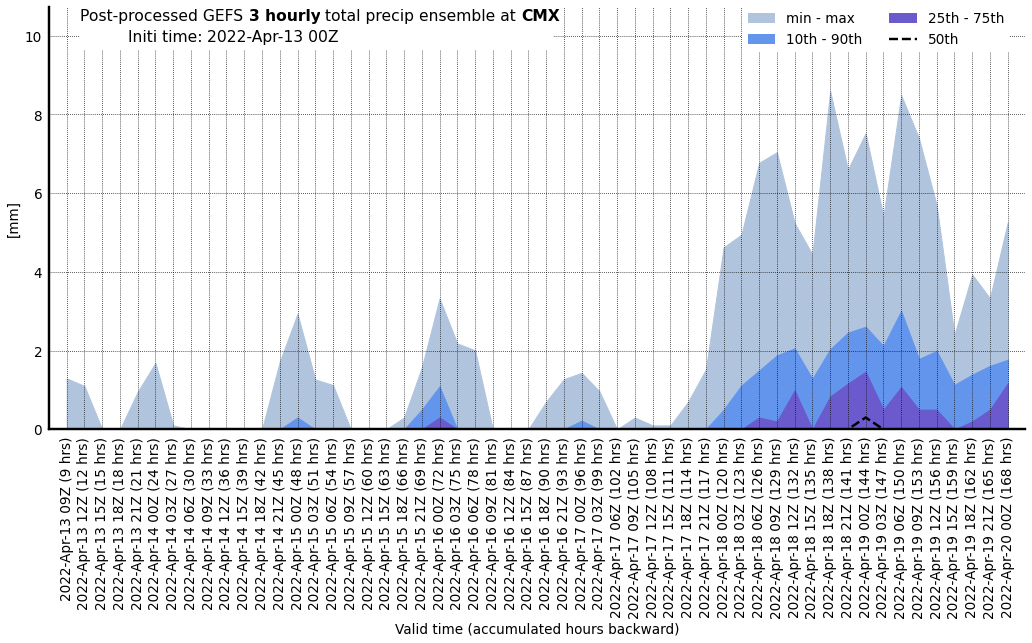

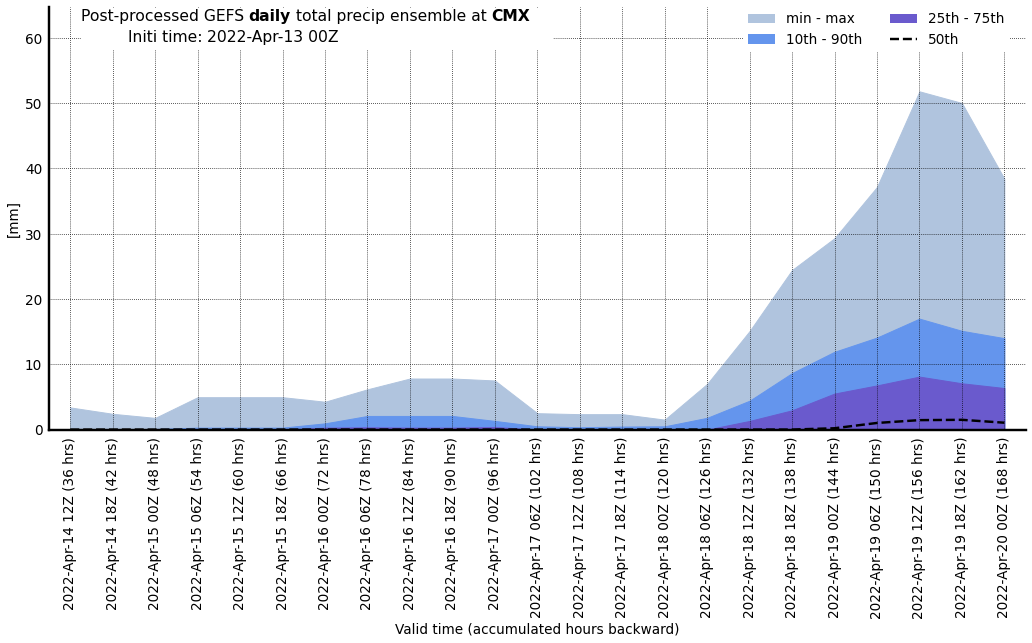

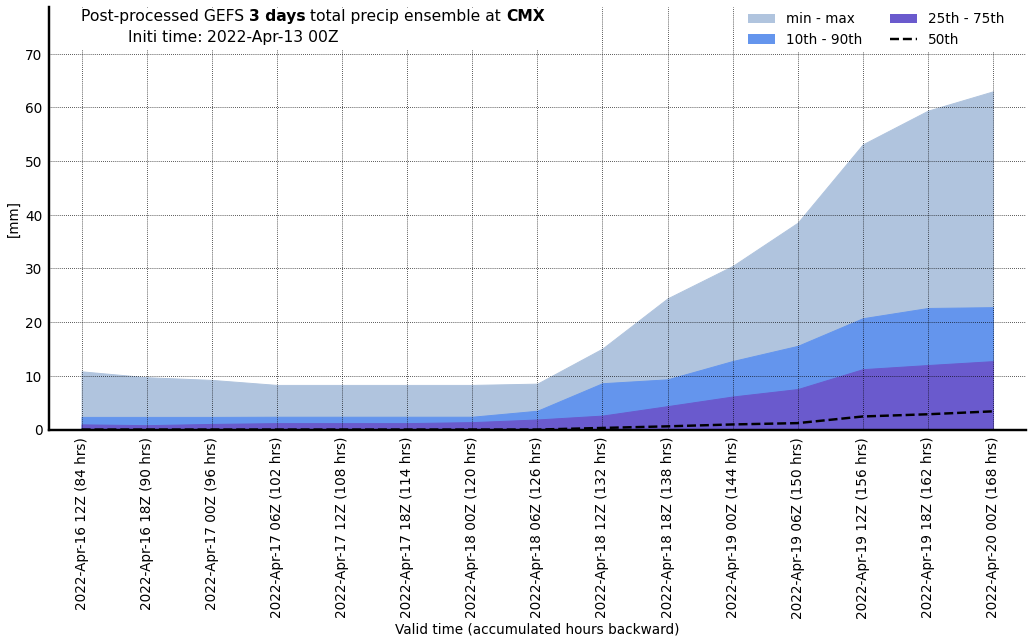

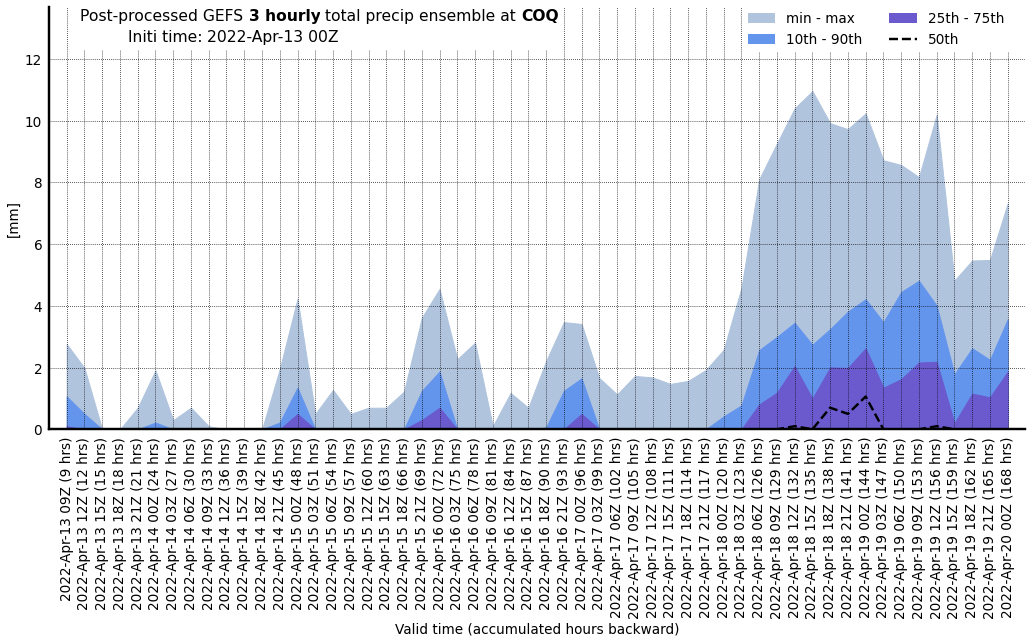

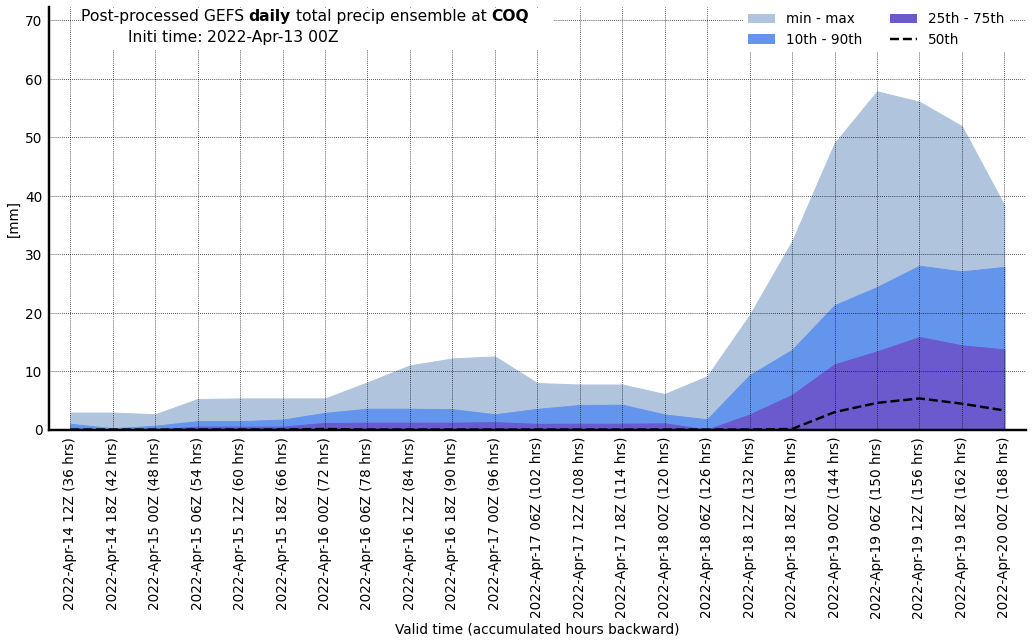

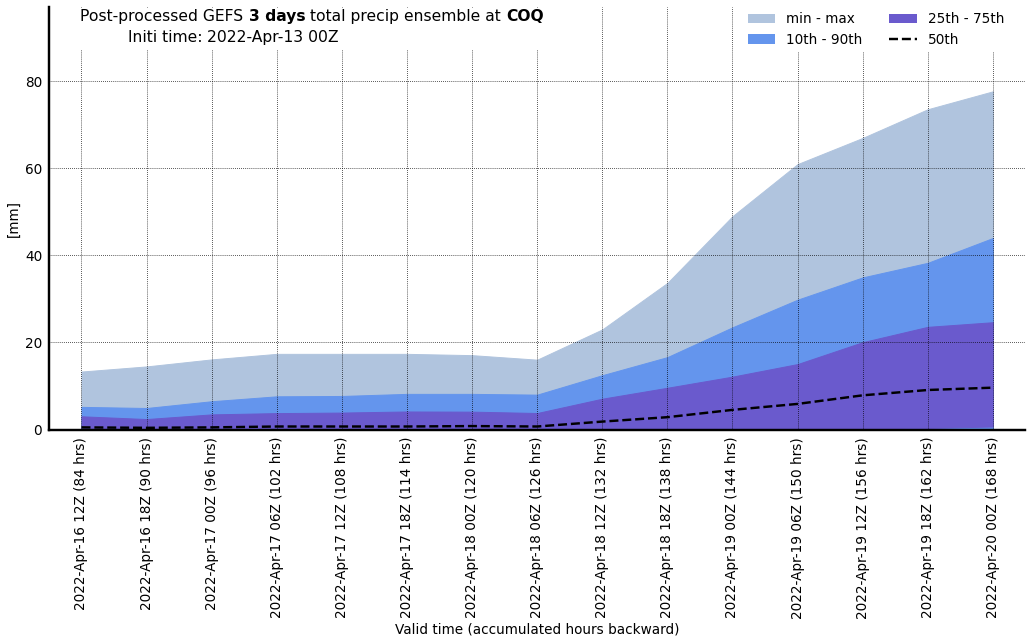

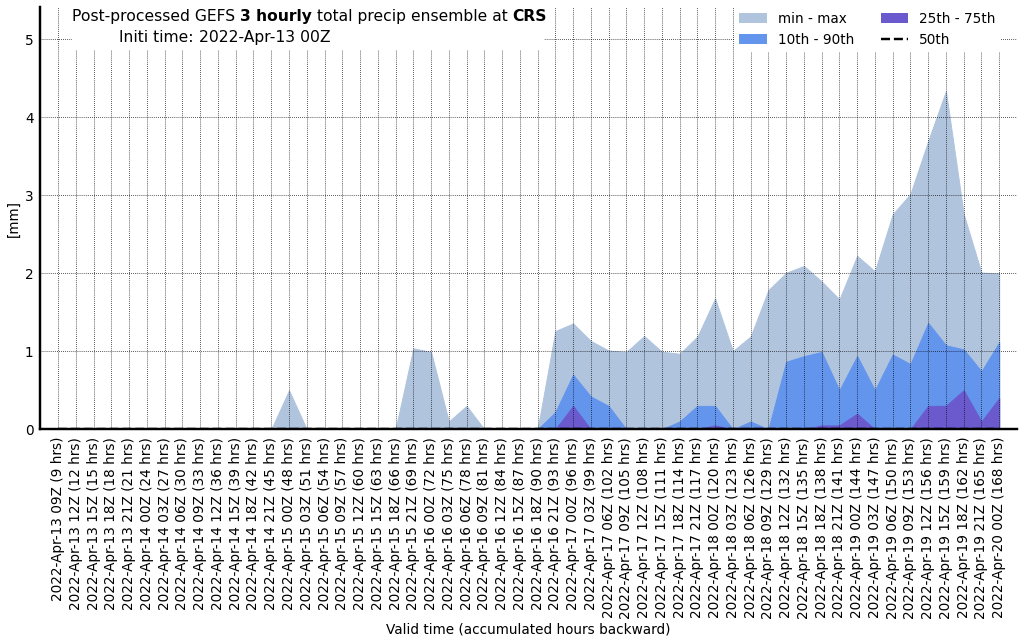

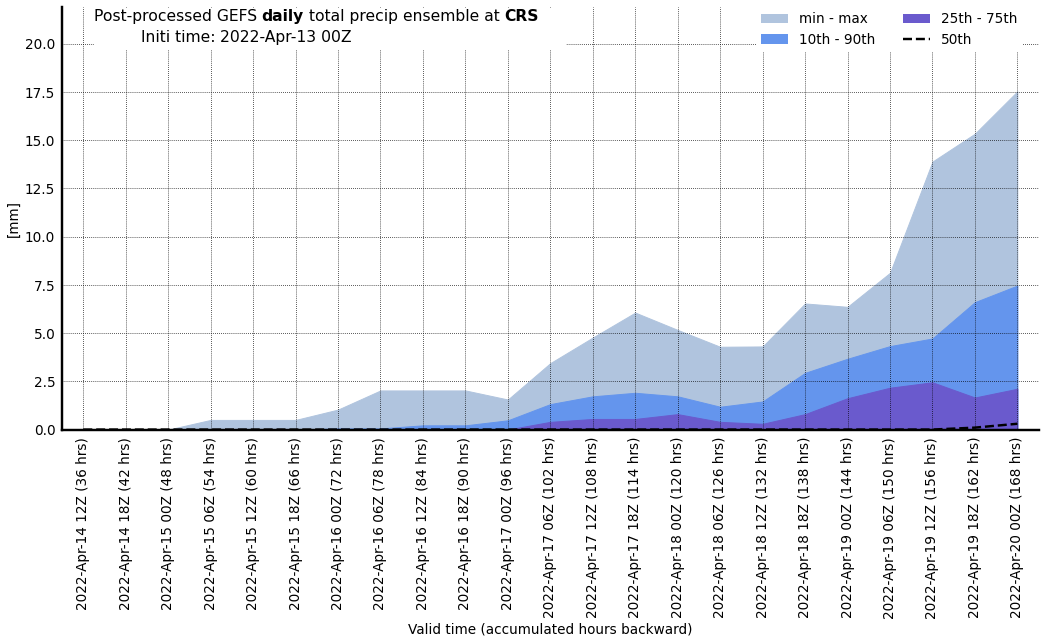

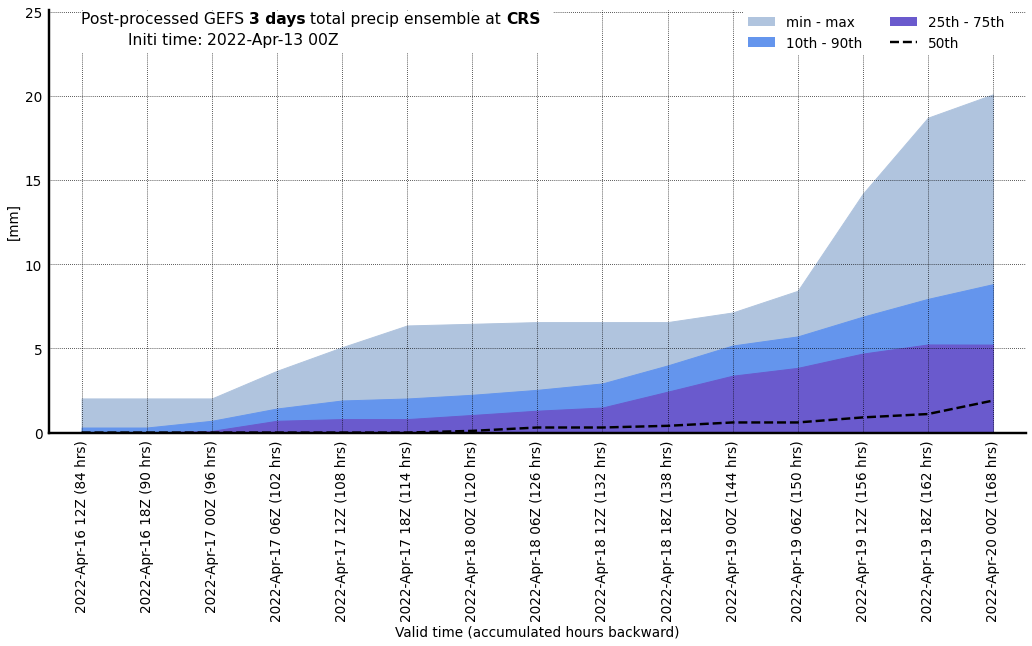

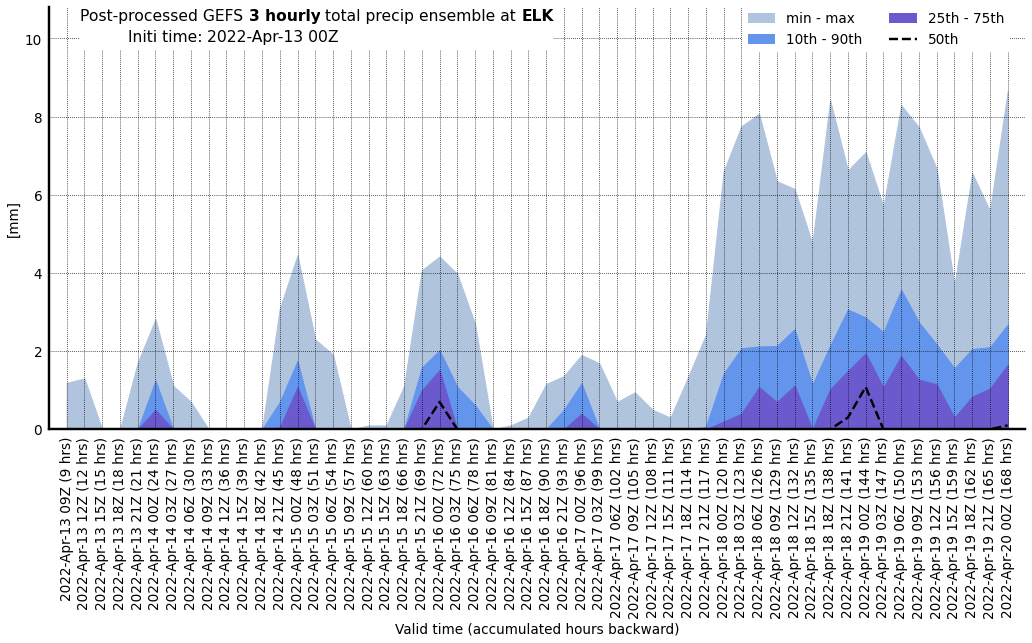

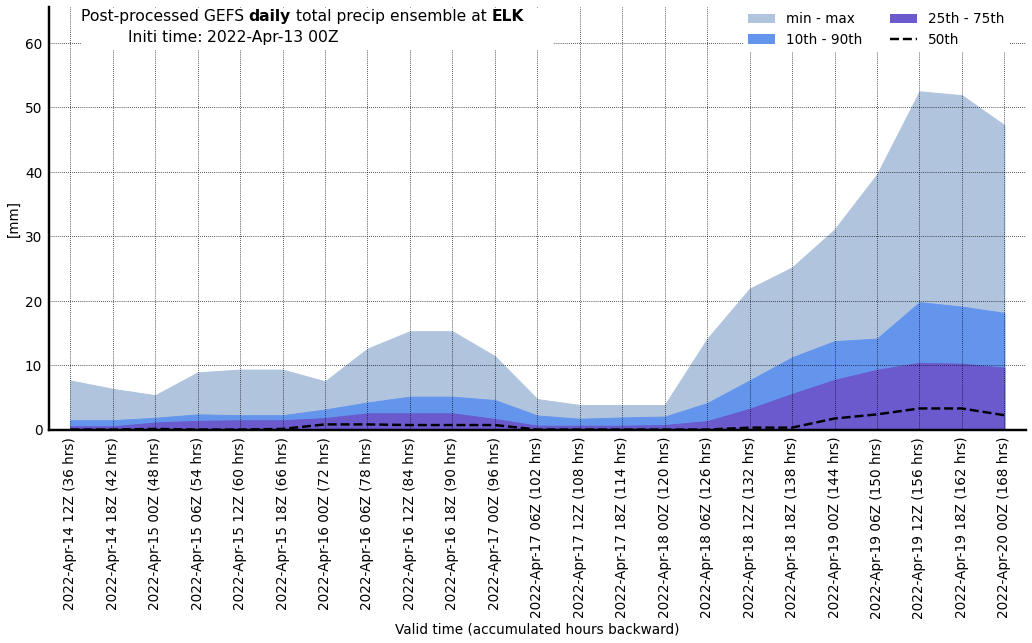

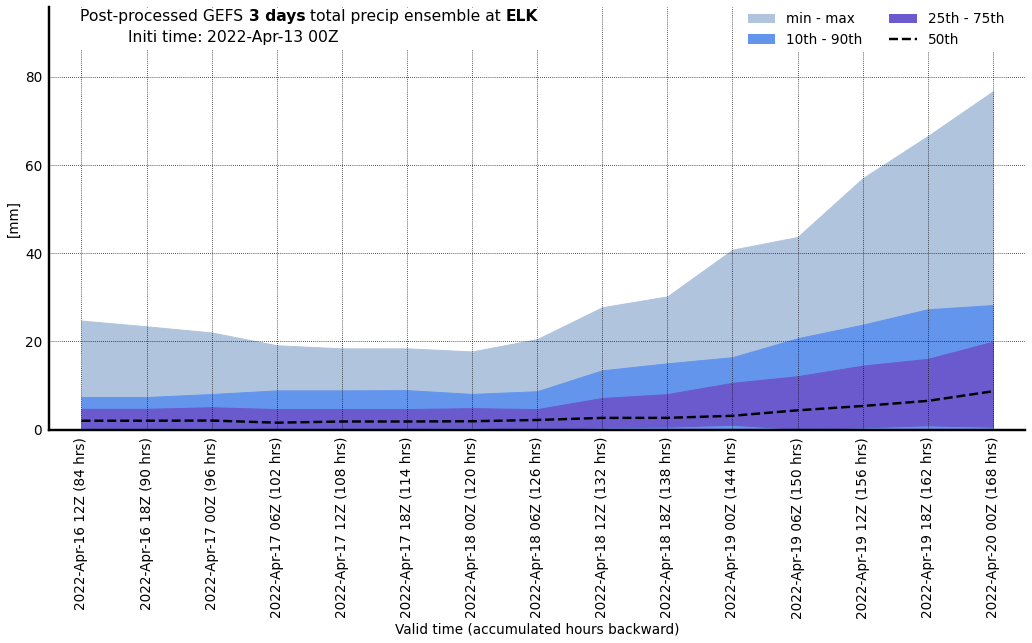

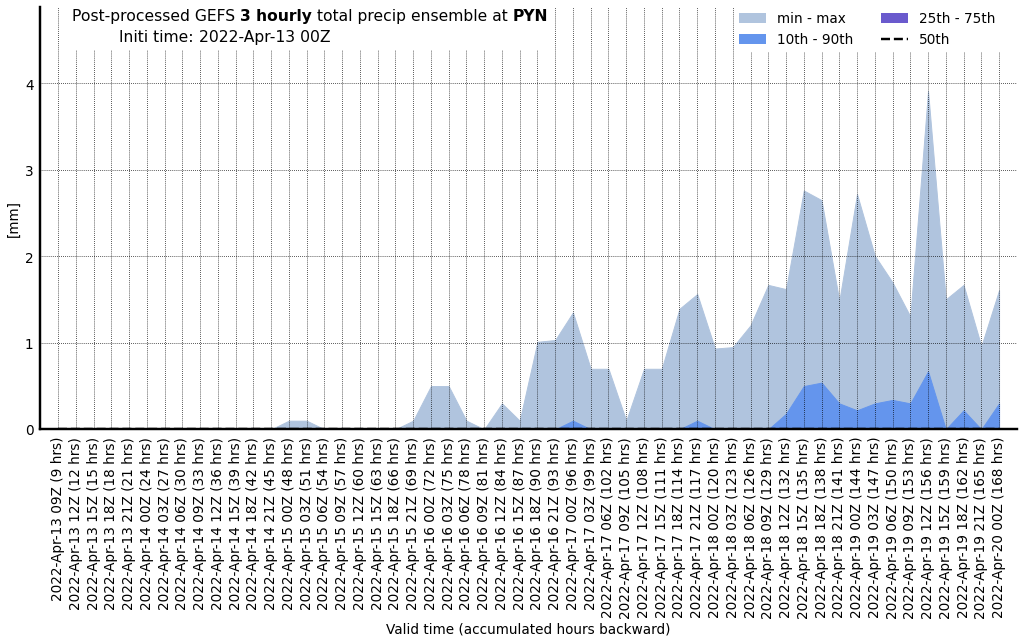

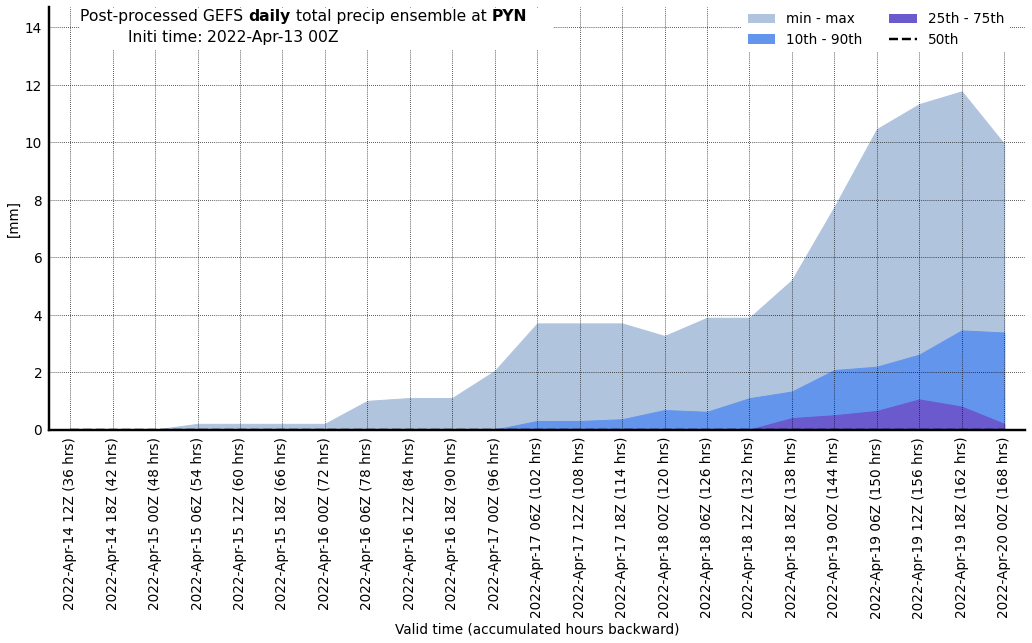

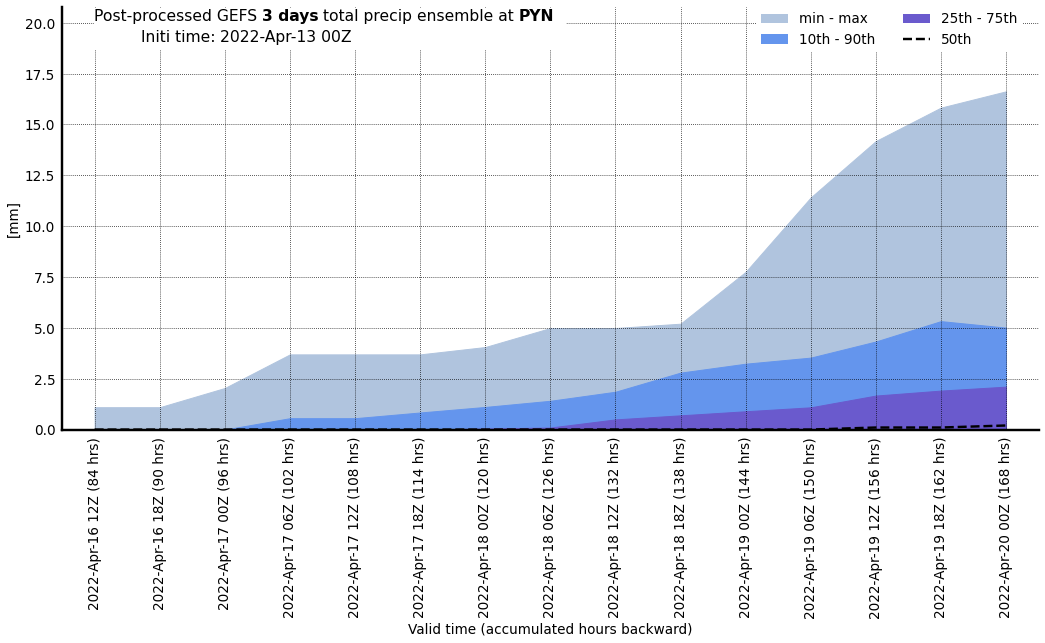

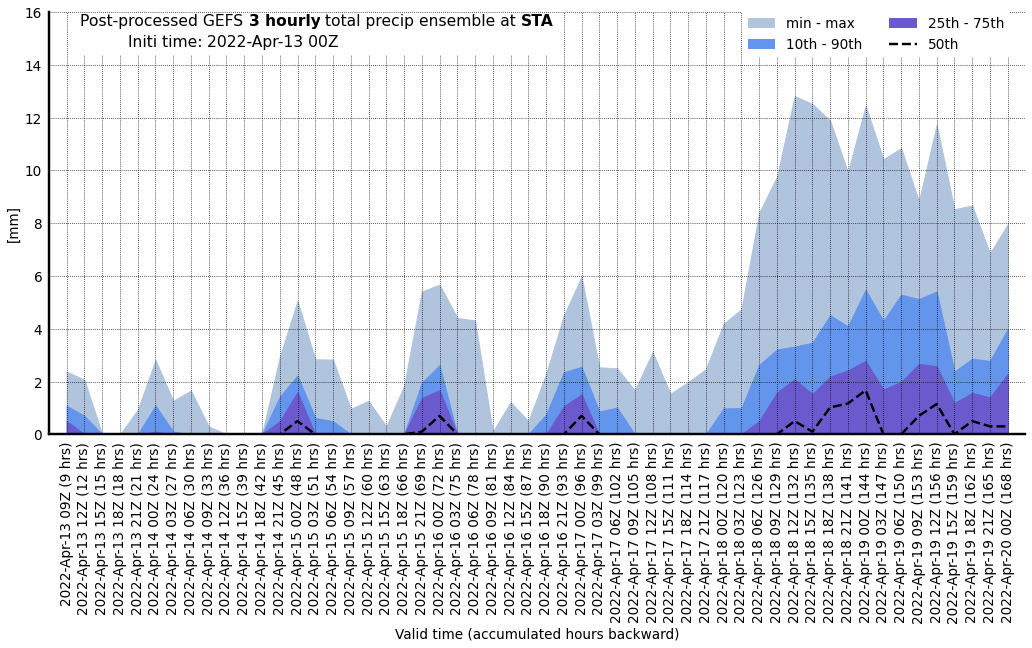

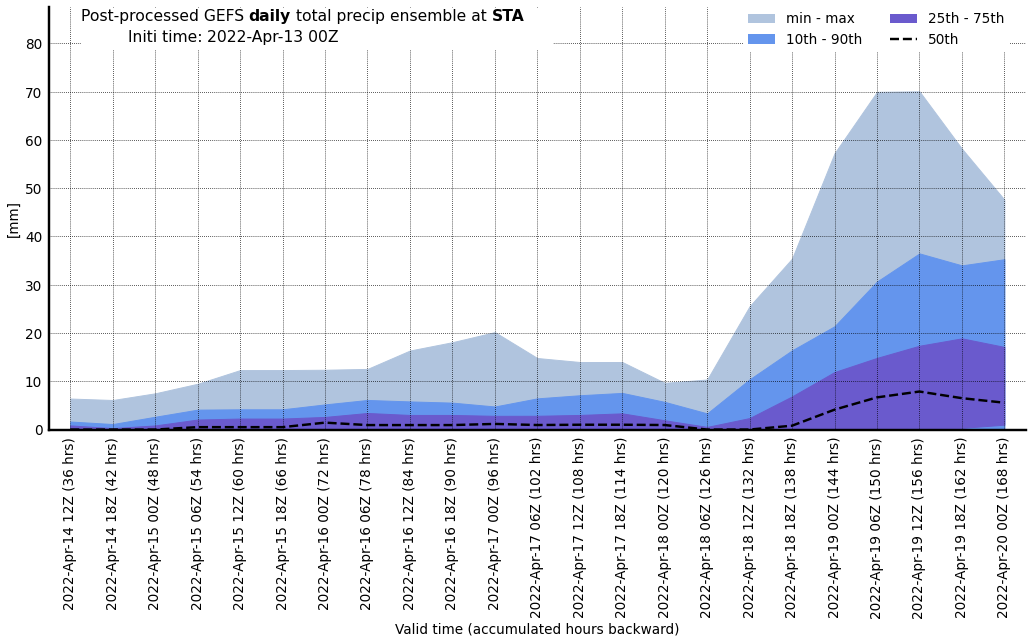

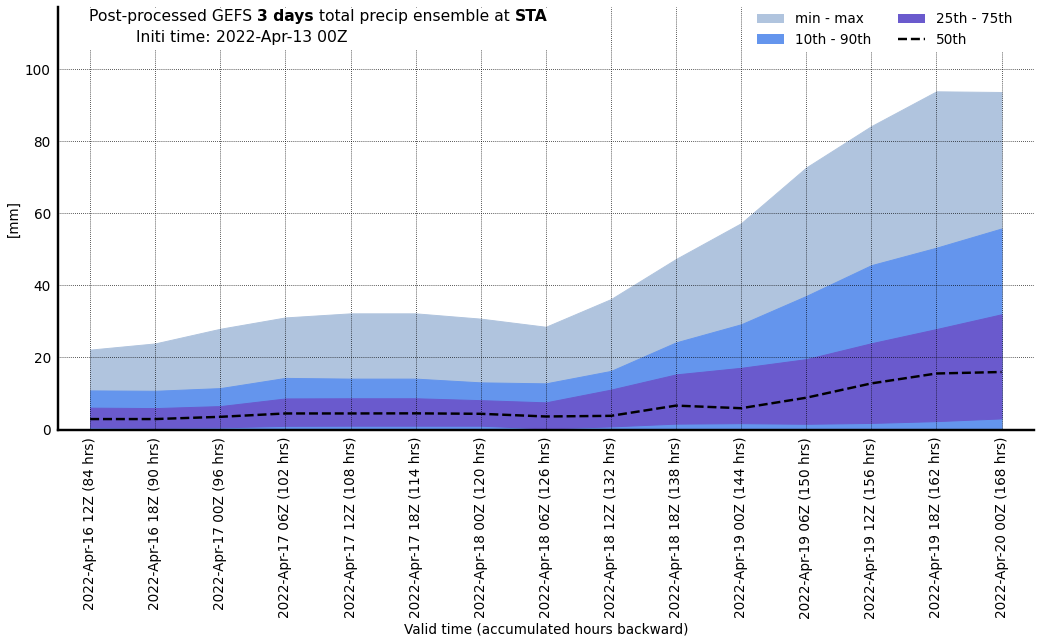

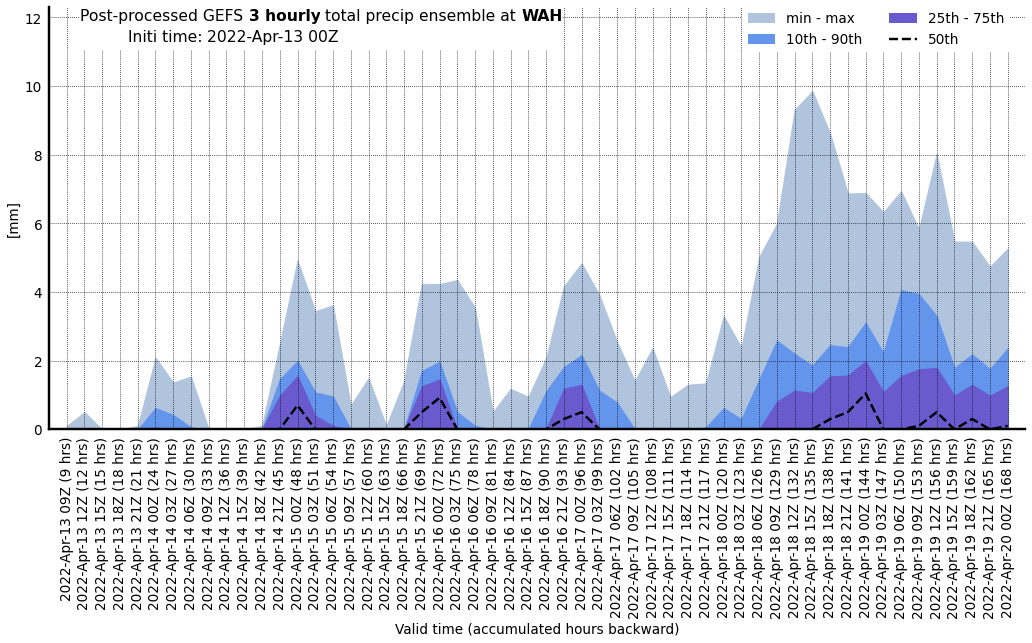

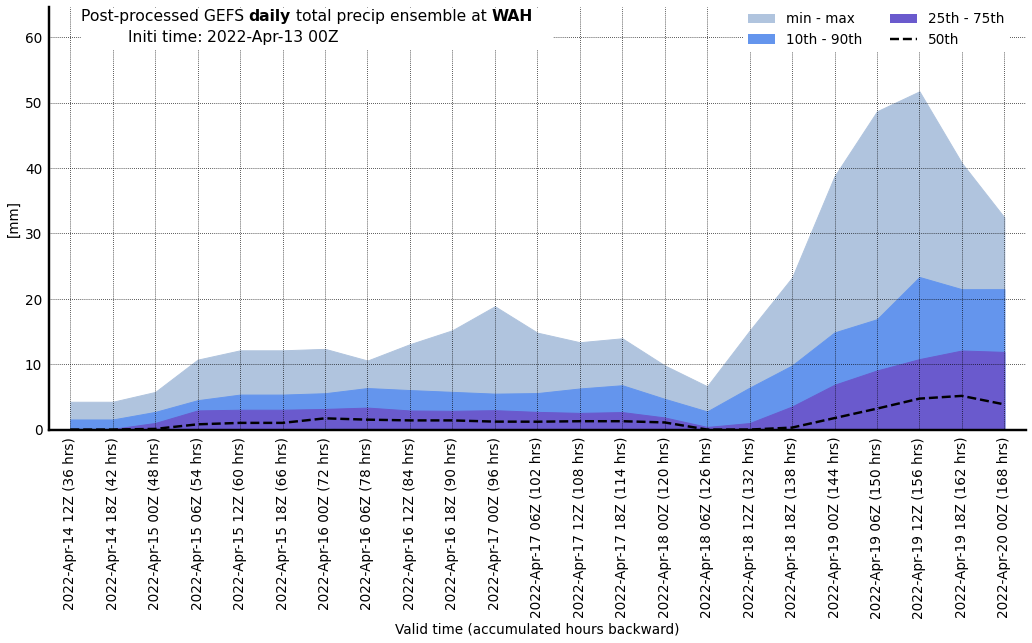

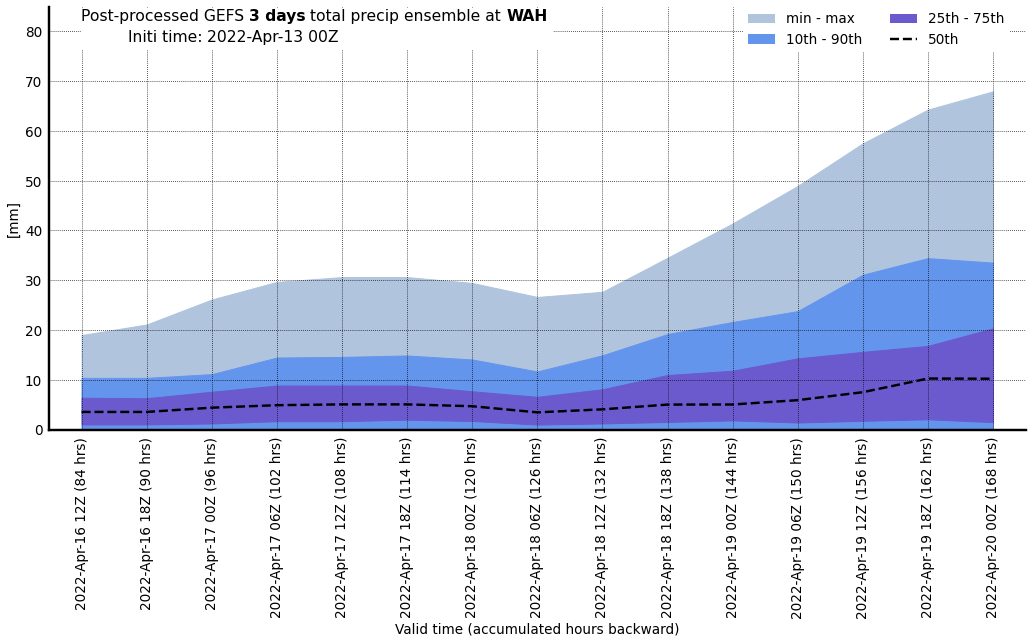

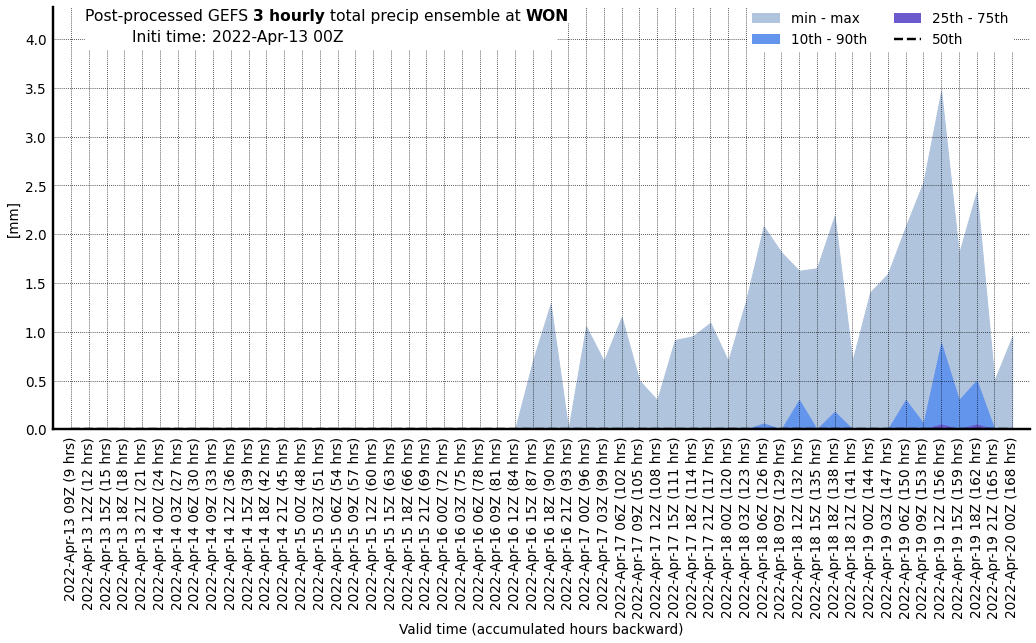

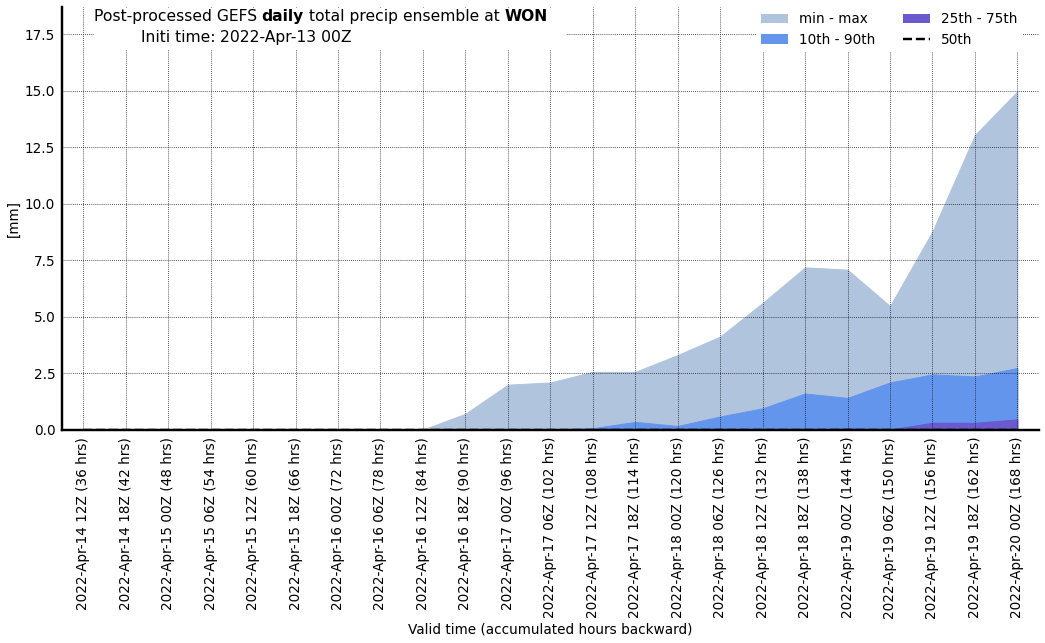

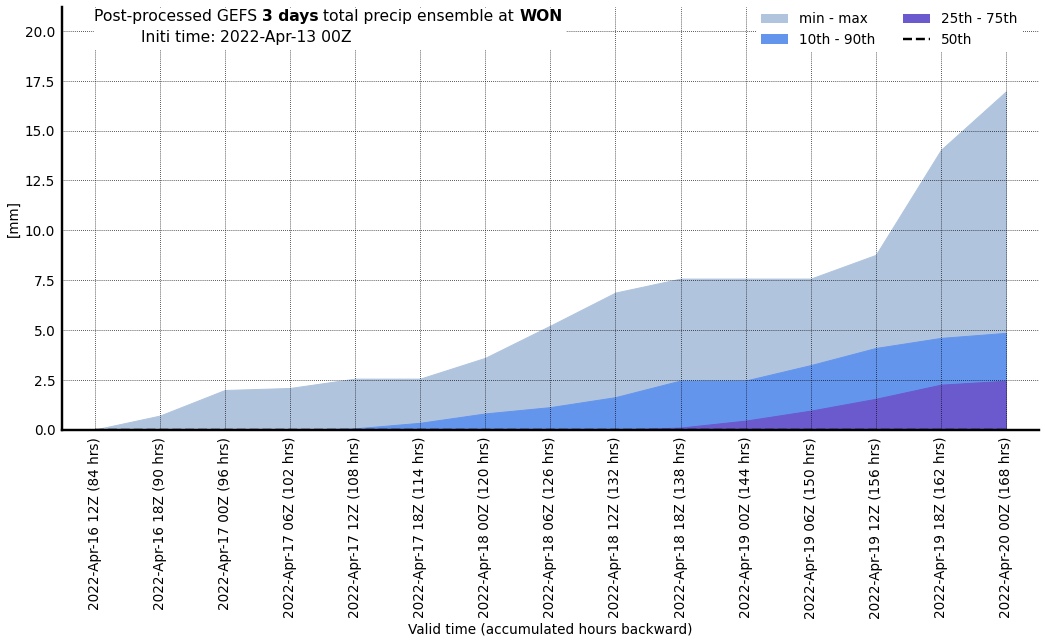

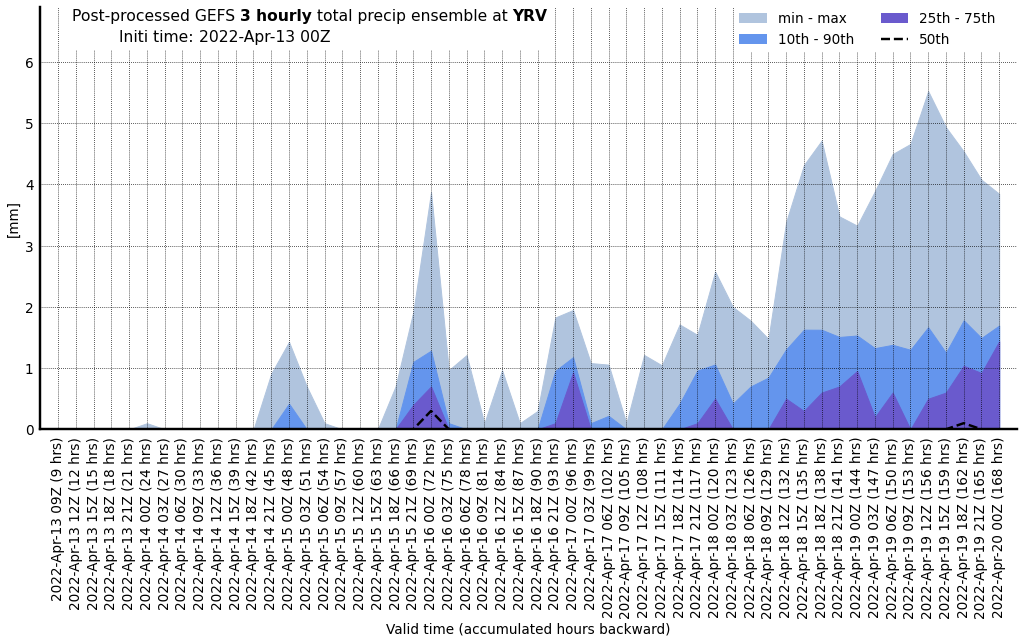

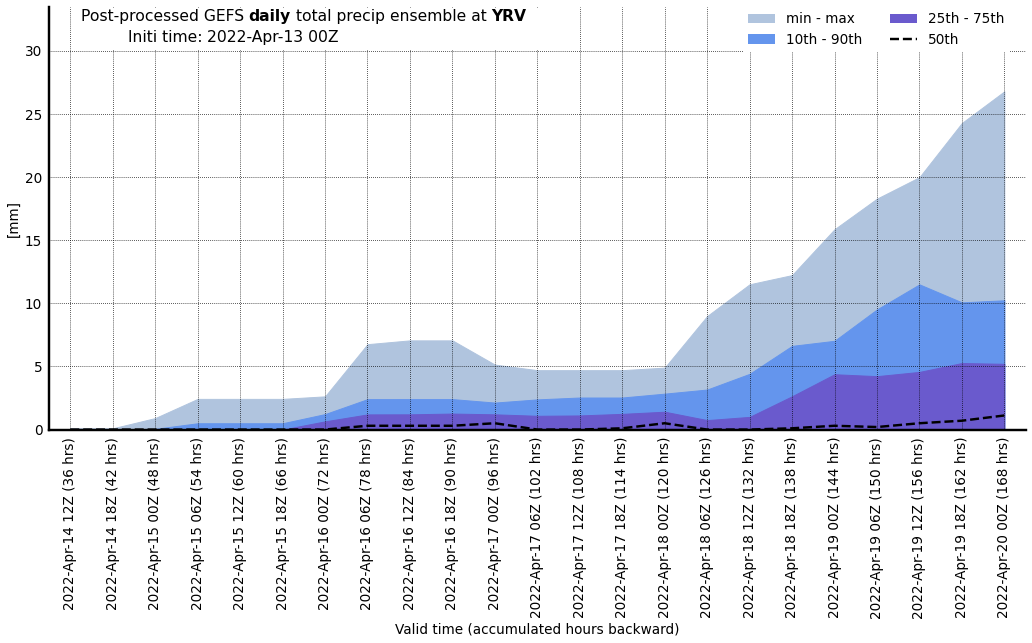

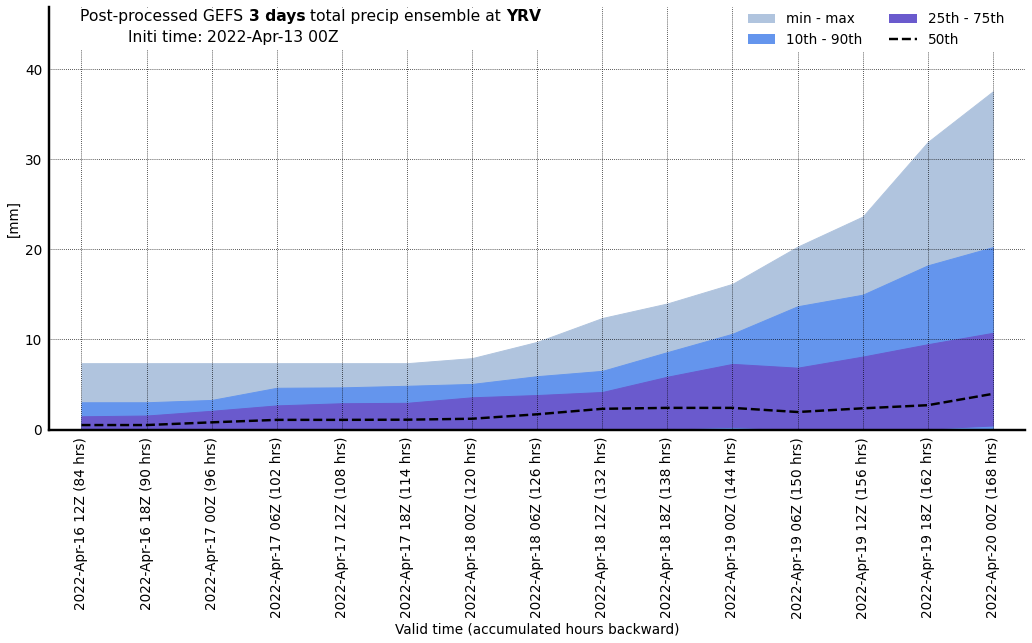

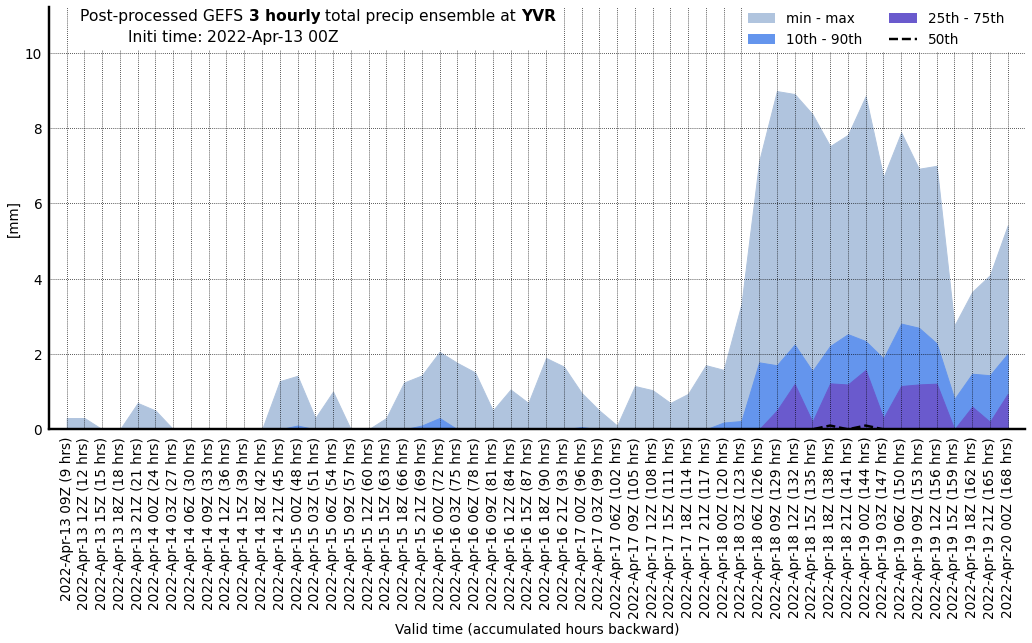

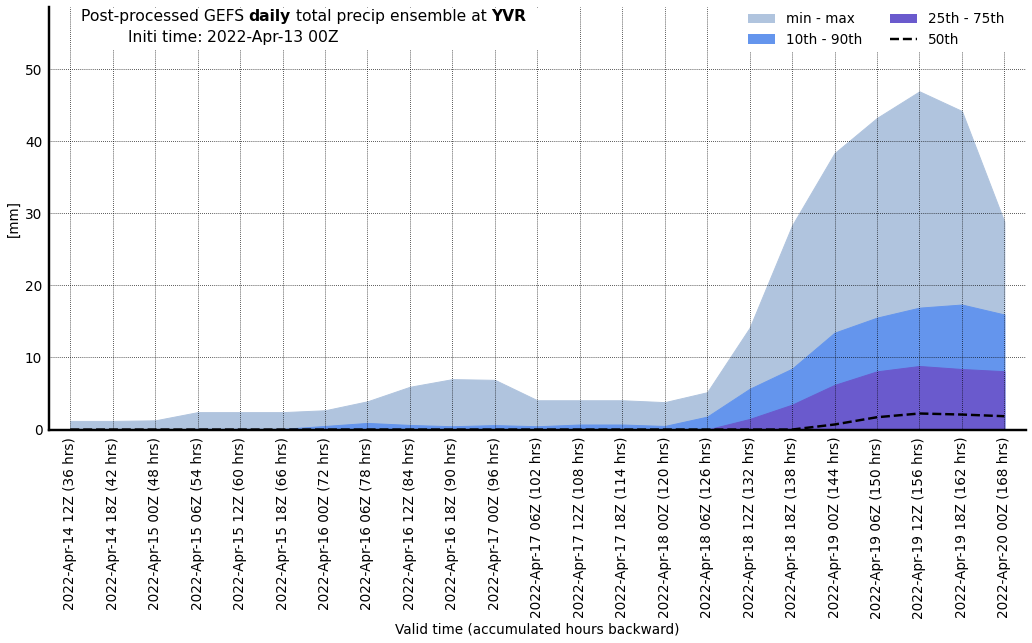

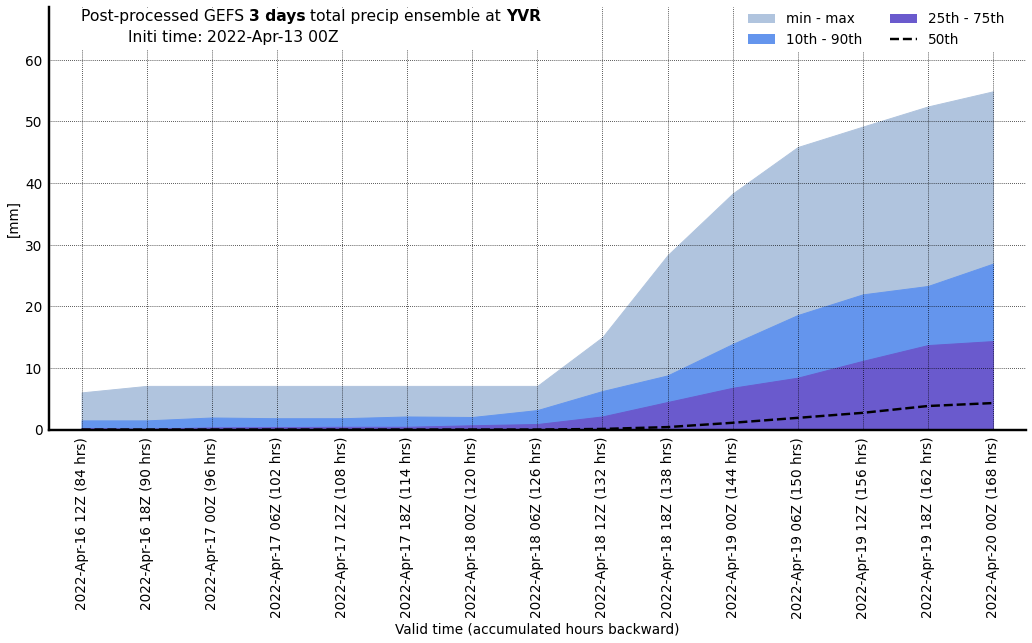

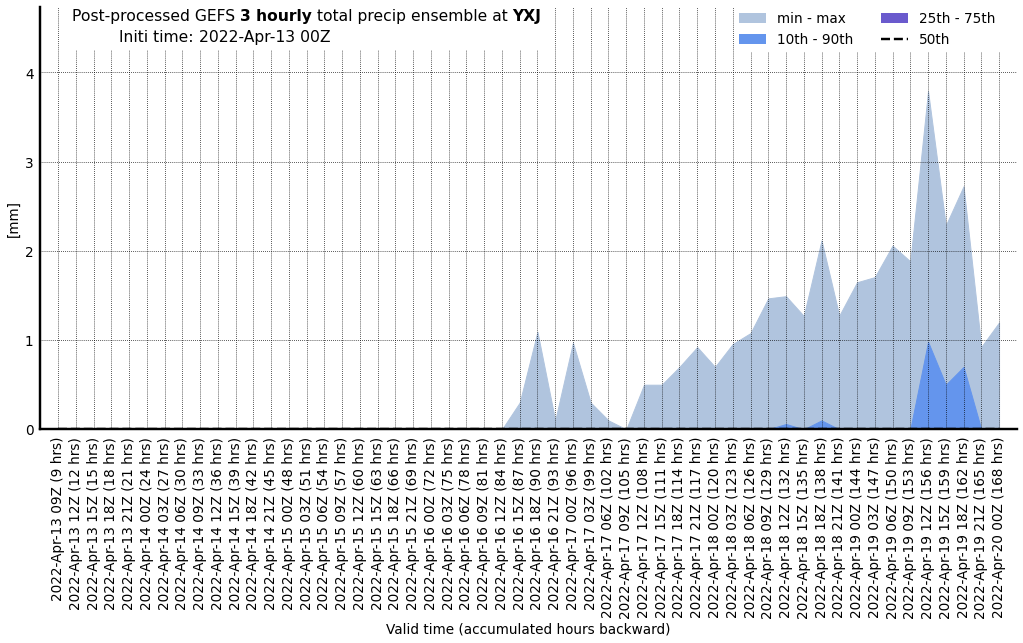

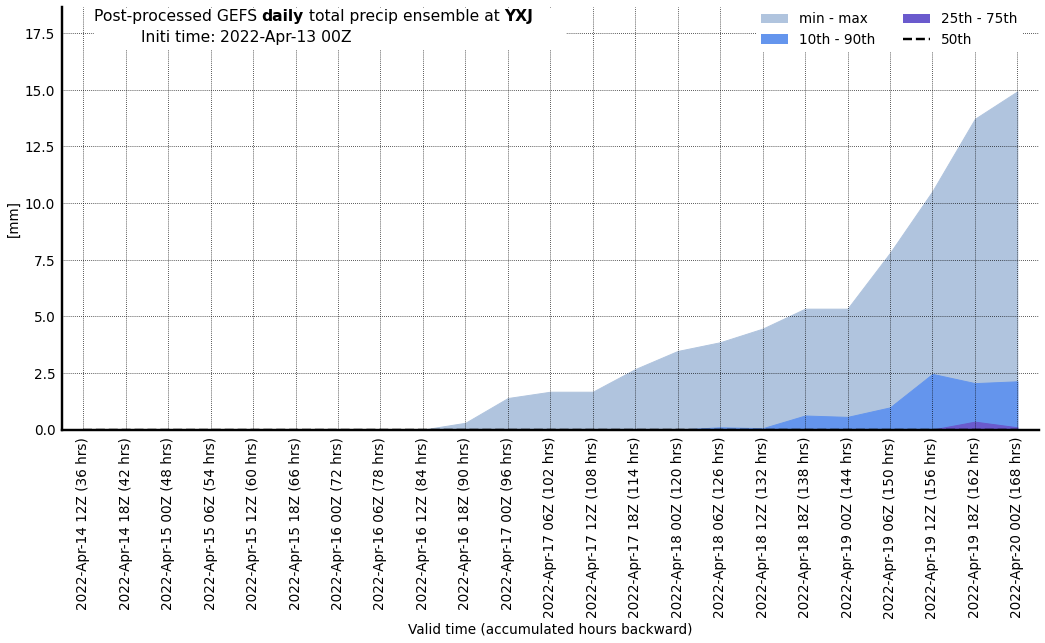

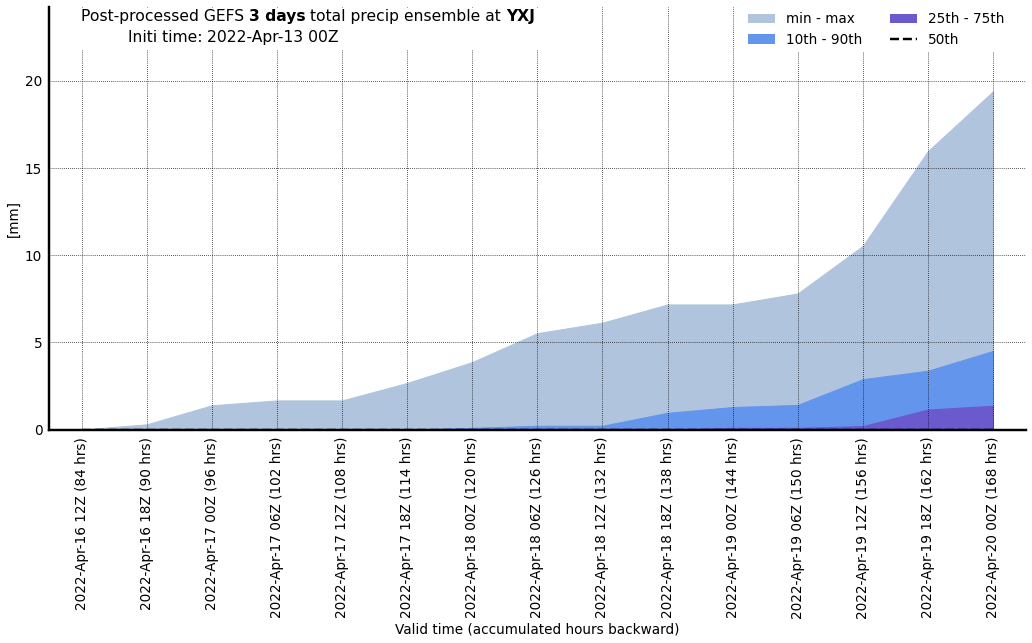

In [27]:
for n in range(L_stn):
    stn_name = stn_names[n]
    ix = indx[n]
    iy = indy[n]
    STN_CNN = CNN_output[:, :, ix, iy]
    
    DATA = {}
    
    for i, q in enumerate(Qs):
        q_str = Qs_str[i]
        DATA['CNN_3_{}'.format(q_str)] = np.quantile(STN_CNN, q, axis=0)
        DATA['CNN_3_max'] =  np.nanmax(STN_CNN, axis=0)
        DATA['CNN_3_min'] =  np.nanmin(STN_CNN, axis=0)
    
    # -------------------- 24 h -------------------- #
    accum_window = 8 # 8x3h = 1 day
    output_freq = 2 # 2x3h = 6h per output
    skip_start = 1 # skip the first 3hr, start from 12hr instead of 9hr
    
    STN_CNN_24, inds_start, inds_end = accum_slide_window_stn(STN_CNN, accum_window, output_freq, skip_start)

    LEADs_24H_hrs = LEADs_3H_hrs[inds_end]

    for i, q in enumerate(Qs):
        q_str = Qs_str[i]
        DATA['CNN_24_{}'.format(q_str)] = np.quantile(STN_CNN_24, q, axis=0)
        DATA['CNN_24_max'] =  np.nanmax(STN_CNN_24, axis=0)
        DATA['CNN_24_min'] =  np.nanmin(STN_CNN_24, axis=0)
        
    # -------------------- 72 h -------------------- #
    accum_window = 24 # 24x3h = 3 day
    output_freq = 2 # 2x3h = 6h per output
    skip_start = 1 # skip the first 3hr, start from 12hr instead of 9hr 

    STN_CNN_72, inds_start, inds_end = accum_slide_window_stn(STN_CNN, accum_window, output_freq, skip_start)

    LEADs_72H_hrs = LEADs_3H_hrs[inds_end]

    for i, q in enumerate(Qs):
        q_str = Qs_str[i]
        DATA['CNN_72_{}'.format(q_str)] = np.quantile(STN_CNN_72, q, axis=0)
        DATA['CNN_72_max'] =  np.nanmax(STN_CNN_72, axis=0)
        DATA['CNN_72_min'] =  np.nanmin(STN_CNN_72, axis=0)
        
    plot_stn(DATA, LEADs_3H_hrs, dt_utc_now, accum=3, accum_str='3 hourly', stn_name=stn_name, COLORS=COLORS, font_text=font_text)
    plot_stn(DATA, LEADs_24H_hrs, dt_utc_now, accum=24, accum_str='daily', stn_name=stn_name, COLORS=COLORS, font_text=font_text)
    plot_stn(DATA, LEADs_72H_hrs, dt_utc_now, accum=72, accum_str='3 days', stn_name=stn_name, COLORS=COLORS, font_text=font_text)

In [19]:
accum_window = 8 # 8x3h = 1 day
output_freq = 2 # 2x3h = 6h per output
skip_start = 1 # skip the first 3hr, start from 12hr instead of 9hr 

STN_CNN_24, inds_start, inds_end = accum_slide_window_stn(STN_CNN, accum_window, output_freq, skip_start)

LEADs_24H_hrs = LEADs_3H_hrs[inds_end]

for i, q in enumerate(Qs):
    q_str = Qs_str[i]
    DATA['CNN_24_{}'.format(q_str)] = np.quantile(STN_CNN_24, q, axis=0)
    DATA['CNN_24_max'] =  np.nanmax(STN_CNN_24, axis=0)
    DATA['CNN_24_min'] =  np.nanmin(STN_CNN_24, axis=0)

In [20]:
accum_window = 24 # 24x3h = 3 day
output_freq = 2 # 2x3h = 6h per output
skip_start = 1 # skip the first 3hr, start from 12hr instead of 9hr 

STN_CNN_72, inds_start, inds_end = accum_slide_window_stn(STN_CNN, accum_window, output_freq, skip_start)

LEADs_72H_hrs = LEADs_3H_hrs[inds_end]

for i, q in enumerate(Qs):
    q_str = Qs_str[i]
    DATA['CNN_72_{}'.format(q_str)] = np.quantile(STN_CNN_72, q, axis=0)
    DATA['CNN_72_max'] =  np.nanmax(STN_CNN_72, axis=0)
    DATA['CNN_72_min'] =  np.nanmin(STN_CNN_72, axis=0)

In [21]:
LEADs_3H_hrs

array([  9.,  12.,  15.,  18.,  21.,  24.,  27.,  30.,  33.,  36.,  39.,
        42.,  45.,  48.,  51.,  54.,  57.,  60.,  63.,  66.,  69.,  72.,
        75.,  78.,  81.,  84.,  87.,  90.,  93.,  96.,  99., 102., 105.,
       108., 111., 114., 117., 120., 123., 126., 129., 132., 135., 138.,
       141., 144., 147., 150., 153., 156., 159., 162., 165., 168.])

In [25]:
def plot_stn(DATA, fcst_hrs, dt_utc_now, accum, accum_str, stn_name, COLORS, font_text):

    dt_ini_str = datetime.strftime(dt_utc_now, '%Y-%h-%d %HZ')

    dt_valid = []
    for hrs in fcst_hrs:
        dt_valid.append(datetime.strftime(dt_utc_now+timedelta(hours=hrs), '%Y-%h-%d %HZ')+' ({} hrs)'.format(int(hrs)))



    fig = plt.figure(figsize=(18, 8), dpi=70)#fig_keys['dpi']
    ax = fig.gca()

    ax = plib.ax_decorate(ax, font_text, left_flag=True, bottom_flag=True, bottom_spline=True)
    ax.xaxis.set_tick_params(labelsize=font_text)
    ax.yaxis.set_tick_params(labelsize=font_text)
    ax.xaxis.grid(True)
    ax.grid(color='k')

    # ===== Text ===== #

    handle_title = []

    ax_t1 = fig.add_axes([0.15, 0.802, 0.375, 0.075], facecolor='w')
    [j.set_linewidth(0.0) for j in ax_t1.spines.values()]
    ax_t1.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                      labelleft=False, labeltop=False, labelright=False, labelbottom=False)

    handle_title += plib.string_partial_format(fig, ax_t1, 0, 1, 'left', 'top', 
                                          ['Post-processed GEFS ', accum_str, ' total precip ensemble at ', stn_name], 
                                          ['k',]*4, [font_text+2,]*4, ['normal', 'bold', 'normal', 'bold'])

    handle_title += plib.string_partial_format(fig, ax_t1, 0.1, 0.5, 'left', 'top', 
                                          ['Initi time: ', dt_ini_str], 
                                          ['k',]*2, [font_text+2,]*2, ['normal', 'normal'])


    # ax_t2 = fig.add_axes([0.13, 0.78, 0.029, 0.0285], facecolor='w')
    # [j.set_linewidth(0.0) for j in ax_t2.spines.values()]
    # ax_t2.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
    #                   labelleft=False, labeltop=False, labelright=False, labelbottom=False)

    # handle_title += plib.string_partial_format(fig, ax_t2, 0, 1, 'left', 'top', 
    #                                            ['[mm]',], 
    #                                            ['k',], [font_text,], ['normal',])

    for handle in handle_title:
        handle.set_bbox(dict(facecolor='w', edgecolor='none', pad=0.0, zorder=6))

    # ===== Lines ===== #

    ax.fill_between(fcst_hrs, DATA['CNN_{}_min'.format(accum)], DATA['CNN_{}_max'.format(accum)], color=COLORS[0])
    ax.fill_between(fcst_hrs, DATA['CNN_{}_P10'.format(accum)], DATA['CNN_{}_P90'.format(accum)], color=COLORS[1])
    ax.fill_between(fcst_hrs, DATA['CNN_{}_P25'.format(accum)], DATA['CNN_{}_P75'.format(accum)], color=COLORS[2])
    handle_line = ax.plot(fcst_hrs, DATA['CNN_{}_P50'.format(accum)], 'k--', lw=2.5, label='50th');

    # ===== Ticks & Legend ===== #
    ax.set_ylim([0, np.nanmax(DATA['CNN_{}_max'.format(accum)])*1.25])
    ax.set_xlim([fcst_hrs[0]-3, fcst_hrs[-1]+3]);
    ax.set_xticks(fcst_hrs);
    ax.set_xticklabels(dt_valid, rotation='90');
    ax.set_xlabel('Valid time (accumulated hours backward)', fontsize=font_text);
    ax.set_ylabel('[mm]', fontsize=font_text);

    handle_legneds = []
    handle_legneds.append(patches.Patch(facecolor=COLORS[0], edgecolor='k', linewidth=0, label='min - max'))
    handle_legneds.append(patches.Patch(facecolor=COLORS[1], edgecolor='k', linewidth=0, label='10th - 90th'))
    handle_legneds.append(patches.Patch(facecolor=COLORS[2], edgecolor='k', linewidth=0, label='25th - 75th'))

    ax_lg2 = fig.add_axes([0.67, 0.802, 0.22, 0.075])
    ax_lg2.set_axis_off()
    LG2 = ax_lg2.legend(handles=handle_legneds+handle_line, bbox_to_anchor=(0.0, 0.5), ncol=2, loc=6, prop={'size':font_text}, fancybox=False);
    LG2.get_frame().set_facecolor('w')
    LG2.get_frame().set_linewidth(0)
    LG2.get_frame().set_alpha(1.0)

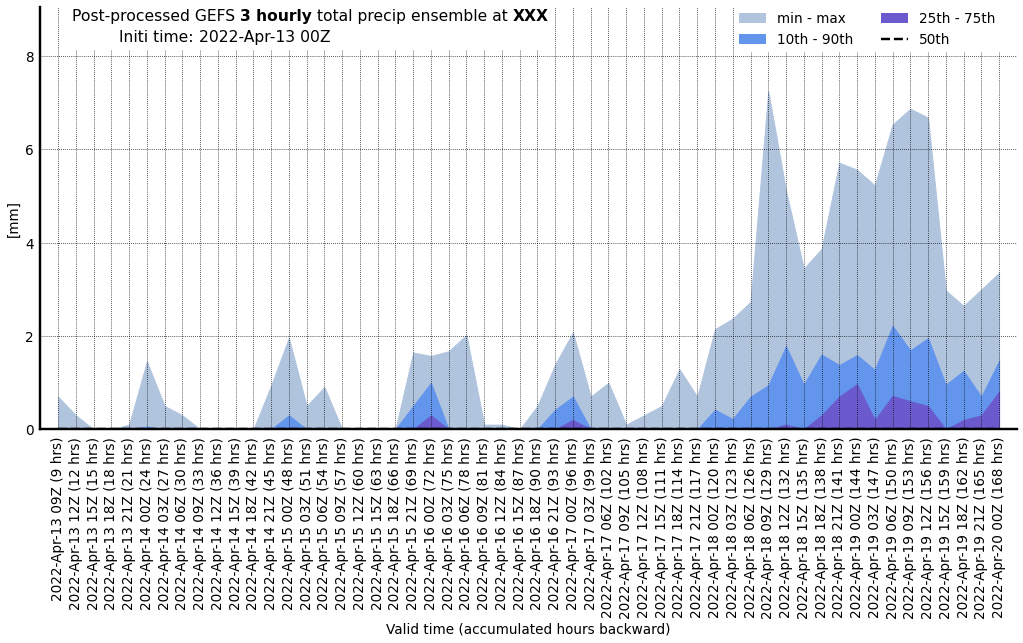

In [22]:
fcst_hrs = LEADs_3H_hrs
accum = 3
accum_str = '3 hourly'
stn_name = 'XXX'
COLORS = [plib.xcolor('light steel blue'), plib.xcolor('corn flower blue'), plib.xcolor('slate blue')]

# ===== #

dt_ini_str = datetime.strftime(dt_utc_now, '%Y-%h-%d %HZ')

dt_valid = []
for hrs in fcst_hrs:
    dt_valid.append(datetime.strftime(dt_utc_now+timedelta(hours=hrs), '%Y-%h-%d %HZ')+' ({} hrs)'.format(int(hrs)))



fig = plt.figure(figsize=(18, 8), dpi=70)#fig_keys['dpi']
ax = fig.gca()

ax = plib.ax_decorate(ax, font_text, left_flag=True, bottom_flag=True, bottom_spline=True)
ax.xaxis.set_tick_params(labelsize=font_text)
ax.yaxis.set_tick_params(labelsize=font_text)
ax.xaxis.grid(True)
ax.grid(color='k')

# ===== Text ===== #

handle_title = []

ax_t1 = fig.add_axes([0.15, 0.802, 0.375, 0.075], facecolor='w')
[j.set_linewidth(0.0) for j in ax_t1.spines.values()]
ax_t1.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                  labelleft=False, labeltop=False, labelright=False, labelbottom=False)

handle_title += plib.string_partial_format(fig, ax_t1, 0, 1, 'left', 'top', 
                                      ['Post-processed GEFS ', accum_str, ' total precip ensemble at ', stn_name], 
                                      ['k',]*4, [font_text+2,]*4, ['normal', 'bold', 'normal', 'bold'])

handle_title += plib.string_partial_format(fig, ax_t1, 0.1, 0.5, 'left', 'top', 
                                      ['Initi time: ', dt_ini_str], 
                                      ['k',]*2, [font_text+2,]*2, ['normal', 'normal'])


# ax_t2 = fig.add_axes([0.13, 0.78, 0.029, 0.0285], facecolor='w')
# [j.set_linewidth(0.0) for j in ax_t2.spines.values()]
# ax_t2.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
#                   labelleft=False, labeltop=False, labelright=False, labelbottom=False)

# handle_title += plib.string_partial_format(fig, ax_t2, 0, 1, 'left', 'top', 
#                                            ['[mm]',], 
#                                            ['k',], [font_text,], ['normal',])

for handle in handle_title:
    handle.set_bbox(dict(facecolor='w', edgecolor='none', pad=0.0, zorder=6))

# ===== Lines ===== #

ax.fill_between(fcst_hrs, DATA['CNN_{}_min'.format(accum)], DATA['CNN_{}_max'.format(accum)], color=COLORS[0])
ax.fill_between(fcst_hrs, DATA['CNN_{}_P10'.format(accum)], DATA['CNN_{}_P90'.format(accum)], color=COLORS[1])
ax.fill_between(fcst_hrs, DATA['CNN_{}_P25'.format(accum)], DATA['CNN_{}_P75'.format(accum)], color=COLORS[2])
handle_line = ax.plot(fcst_hrs, DATA['CNN_{}_P50'.format(accum)], 'k--', lw=2.5, label='50th');

# ===== Ticks & Legend ===== #
ax.set_ylim([0, np.nanmax(DATA['CNN_{}_max'.format(accum)])*1.25])
ax.set_xlim([fcst_hrs[0]-3, fcst_hrs[-1]+3]);
ax.set_xticks(fcst_hrs);
ax.set_xticklabels(dt_valid, rotation='90');
ax.set_xlabel('Valid time (accumulated hours backward)', fontsize=font_text);
ax.set_ylabel('[mm]', fontsize=font_text);

handle_legneds = []
handle_legneds.append(patches.Patch(facecolor=COLORS[0], edgecolor='k', linewidth=0, label='min - max'))
handle_legneds.append(patches.Patch(facecolor=COLORS[1], edgecolor='k', linewidth=0, label='10th - 90th'))
handle_legneds.append(patches.Patch(facecolor=COLORS[2], edgecolor='k', linewidth=0, label='25th - 75th'))

ax_lg2 = fig.add_axes([0.67, 0.802, 0.22, 0.075])
ax_lg2.set_axis_off()
LG2 = ax_lg2.legend(handles=handle_legneds+handle_line, bbox_to_anchor=(0.0, 0.5), ncol=2, loc=6, prop={'size':font_text}, fancybox=False);
LG2.get_frame().set_facecolor('w')
LG2.get_frame().set_linewidth(0)
LG2.get_frame().set_alpha(1.0)


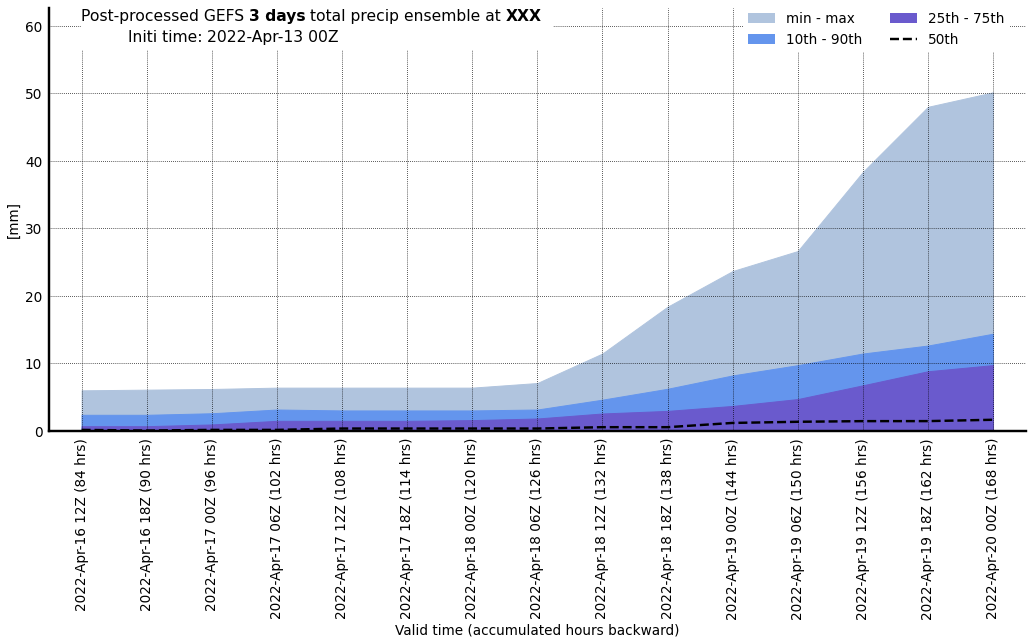

In [23]:
fcst_hrs = LEADs_72H_hrs
accum = 72
accum_str = '3 days'
stn_name = 'XXX'
COLORS = [plib.xcolor('light steel blue'), plib.xcolor('corn flower blue'), plib.xcolor('slate blue')]

# ===== #

dt_ini_str = datetime.strftime(dt_utc_now, '%Y-%h-%d %HZ')

dt_valid = []
for hrs in fcst_hrs:
    dt_valid.append(datetime.strftime(dt_utc_now+timedelta(hours=hrs), '%Y-%h-%d %HZ')+' ({} hrs)'.format(int(hrs)))



fig = plt.figure(figsize=(18, 8), dpi=70)#fig_keys['dpi']
ax = fig.gca()

ax = plib.ax_decorate(ax, font_text, left_flag=True, bottom_flag=True, bottom_spline=True)
ax.xaxis.set_tick_params(labelsize=font_text)
ax.yaxis.set_tick_params(labelsize=font_text)
ax.xaxis.grid(True)
ax.grid(color='k')

# ===== Text ===== #

handle_title = []

ax_t1 = fig.add_axes([0.15, 0.804, 0.375, 0.075], facecolor='w')
[j.set_linewidth(0.0) for j in ax_t1.spines.values()]
ax_t1.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                  labelleft=False, labeltop=False, labelright=False, labelbottom=False)

handle_title += plib.string_partial_format(fig, ax_t1, 0, 1, 'left', 'top', 
                                      ['Post-processed GEFS ', accum_str, ' total precip ensemble at ', stn_name], 
                                      ['k',]*4, [font_text+2,]*4, ['normal', 'bold', 'normal', 'bold'])

handle_title += plib.string_partial_format(fig, ax_t1, 0.1, 0.5, 'left', 'top', 
                                      ['Initi time: ', dt_ini_str], 
                                      ['k',]*2, [font_text+2,]*2, ['normal', 'normal'])


# ax_t2 = fig.add_axes([0.13, 0.78, 0.029, 0.0285], facecolor='w')
# [j.set_linewidth(0.0) for j in ax_t2.spines.values()]
# ax_t2.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
#                   labelleft=False, labeltop=False, labelright=False, labelbottom=False)

# handle_title += plib.string_partial_format(fig, ax_t2, 0, 1, 'left', 'top', 
#                                            ['[mm]',], 
#                                            ['k',], [font_text,], ['normal',])

for handle in handle_title:
    handle.set_bbox(dict(facecolor='w', edgecolor='none', pad=0.0, zorder=6))

# ===== Lines ===== #

ax.fill_between(fcst_hrs, DATA['CNN_{}_min'.format(accum)], DATA['CNN_{}_max'.format(accum)], color=COLORS[0])
ax.fill_between(fcst_hrs, DATA['CNN_{}_P10'.format(accum)], DATA['CNN_{}_P90'.format(accum)], color=COLORS[1])
ax.fill_between(fcst_hrs, DATA['CNN_{}_P25'.format(accum)], DATA['CNN_{}_P75'.format(accum)], color=COLORS[2])
handle_line = ax.plot(fcst_hrs, DATA['CNN_{}_P50'.format(accum)], 'k--', lw=2.5, label='50th');

# ===== Ticks & Legend ===== #
ax.set_ylim([0, np.nanmax(DATA['CNN_{}_max'.format(accum)])*1.25])
ax.set_xlim([fcst_hrs[0]-3, fcst_hrs[-1]+3]);
ax.set_xticks(fcst_hrs);
ax.set_xticklabels(dt_valid, rotation='90');
ax.set_xlabel('Valid time (accumulated hours backward)', fontsize=font_text);
ax.set_ylabel('[mm]', fontsize=font_text);

handle_legneds = []
handle_legneds.append(patches.Patch(facecolor=COLORS[0], edgecolor='k', linewidth=0, label='min - max'))
handle_legneds.append(patches.Patch(facecolor=COLORS[1], edgecolor='k', linewidth=0, label='10th - 90th'))
handle_legneds.append(patches.Patch(facecolor=COLORS[2], edgecolor='k', linewidth=0, label='25th - 75th'))

ax_lg2 = fig.add_axes([0.67, 0.804, 0.22, 0.075])
ax_lg2.set_axis_off()
LG2 = ax_lg2.legend(handles=handle_legneds+handle_line, bbox_to_anchor=(0.0, 0.5), ncol=2, loc=6, prop={'size':font_text}, fancybox=False);
LG2.get_frame().set_facecolor('w')
LG2.get_frame().set_linewidth(0)
LG2.get_frame().set_alpha(1.0)
